In [82]:
import numpy as np
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


import matplotlib.pyplot as plt

import  tensorflow as tf
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus

In [83]:
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

#util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [84]:
# Etapa 1 - preparar o dataset
'''
fazer o download do MNIST dataset com imagens de digitos escritos à mão para fazer a
sua classificação (já pré-preparados)
dataset: https://s3.amazonaws.com/img-datasets/mnist.npz
O ficheiro já tem tudo separado nos ficheiros {x_test.npy, x_train.npy, y_test.npy,
y_train.npy}
Os atributos de entrada estão com matrizes 3D(imagem, largura,altura) e os atributos de
saída é uma lista com o número correspondente
'''
def load_mnist_dataset(path='mnist.npz'):
    #path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

In [85]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar 
'''
criar uma rede neuronal convolucionária simples.
- a primeira camada escondida é uma camada convolucionária chamada Convolution2D.
A camada tem 32 feature maps , cada um de dimensão 5×5 e uma função de activação 'rectifier activation
function'.
trata-se de uma camada de input, à espera de imagens com a estrutura [pixels][width][height].
- A segunda camada é de pooling que utiliza o max de MaxPooling2D.
está configurado para uma pool size de 2×2.
- A camada seguinte é de regularização que usa Dropout.
Está configurado para excluir aleatóriamente 20% dos neuronios na camada para reduzir overfitting.
- A camada seguinte converte os dados da matriz 2D num vector chamado Flatten.
Assim permite-se que esse output seja tratado por uma camada completamente ligada standard.
- A camada seguinte é uma completamente ligada com 128 neuronios e uma fução de activação 'rectifier activation
function'.
- Finalmente a camada de saida tem 10 neuronios correspondentes às 10 classes e uma função de activação softmax
para apresentar na saida uma especie de probabilidade para cada classe.
- O modelo é treinado utilizando logarithmic loss e o algoritmo de gradient descent ADAM.
'''
def create_compile_model_cnn_simples(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [86]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar 
'''
criar uma rede neuronal convolucionária mais complexa.
- Convolutional layer com 30 feature maps de dimensão 5×5.
- Pooling layer que passa o máximo de 2*2 patches.
- Convolutional layer com 15 feature maps de dimensão 3×3.
- Pooling layer que passa o máximo de 2*2 patches.
- Dropout layer com probabilidade de 20%.
- Flatten layer.
- Fully connected layer com 128 neuronios e activação rectifier.
- Fully connected layer com 50 neuronios e activação rectifier.
- Output layer.
- O modelo é treinado utilizando logarithmic loss e o algoritmo de gradient descent ADAM.
'''
def create_compile_model_cnn_plus(num_classes):
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [87]:
def mnist_utilizando_cnn_simples():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    # transformar para o formato [instancias][pixeis][largura][altura]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    # definir a topologia da rede e compilar
    model = create_compile_model_cnn_simples(num_classes)
    print_model(model,"model_simples.png")
    # treinar a rede
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,
    batch_size=200, verbose=2)
    print_history_accuracy(history)
    #print_history_loss(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    print('Scores: ', scores)
    print("Erro modelo MLP: %.2f%%" % (100-scores[1]*100))


In [88]:
def mnist_utilizando_cnn_plus():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    # transformar para o formato [instancias][pixeis][largura][altura]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    # definir a topologia da rede e compilar
    model = create_compile_model_cnn_plus(num_classes)
    print_model(model,"model_plus.png")
    # treinar a rede
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200,
    verbose=2)
    print_history_accuracy(history)
    #print_history_loss(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    print('Scores: ', scores)
    print("Erro modelo MLP: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 56s - loss: 0.4873 - accuracy: 0.8507 - val_loss: 0.1368 - val_accuracy: 0.9595
Epoch 2/10
 - 54s - loss: 0.1335 - accuracy: 0.9590 - val_loss: 0.0685 - val_accuracy: 0.9789
Epoch 3/10
 - 58s - loss: 0.0891 - accuracy: 0.9725 - val_loss: 0.0513 - val_accuracy: 0.9823
Epoch 4/10
 - 55s - loss: 0.0725 - accuracy: 0.9772 - val_loss: 0.0466 - val_accuracy: 0.9848
Epoch 5/10
 - 54s - loss: 0.0604 - accuracy: 0.9813 - val_loss: 0.0362 - val_accuracy: 0.9887
Epoch 6/10
 - 69s - loss: 0.0533 - accuracy: 0.9831 - val_loss: 0.0400 - val_accuracy: 0.9875
Epoch 7/10
 - 57s - loss: 0.0471 - accuracy: 0.9851 - val_loss: 0.0400 - val_accuracy: 0.9867
Epoch 8/10
 - 52s - loss: 0.0437 - accuracy: 0.9859 - val_loss: 0.0323 - val_accuracy: 0.9890
Epoch 9/10
 - 65s - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0303 - val_accuracy: 0.9896
Epoch 10/10
 - 68s - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.0280 - val_accuracy: 0.9910
dict_keys

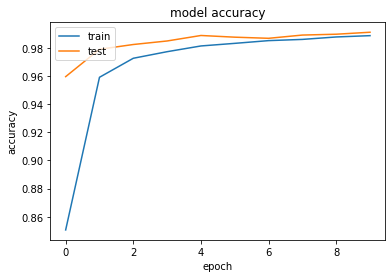

Scores:  [0.027986554385244382, 0.9909999966621399]
Erro modelo MLP: 0.90%


In [89]:
if __name__ == '__main__':
    #mnist_utilizando_cnn_simples()
    mnist_utilizando_cnn_plus()